## ECON 522 Lab - Week 3

Today, we will discuss (1) HAC standard errors, (2) Impulse responses, and (3) some out of sample forecasting

## Problem Set Help

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools

########################################
# 1. Download data from FRED
########################################

# Let's pick a sample series, for example, "GDP" (US Real Gross Domestic Product).
series_id = 'GDP'
data = fred.get_series(series_id)

# Convert to a pandas DataFrame and add a date index. 
# The FRED series might already be properly indexed by date; 
# but let's ensure it is handled consistently:
df = pd.DataFrame(data, columns=[series_id])
df.index = pd.to_datetime(df.index)

# Inspect the first few rows
print(df.head())

# If the data frequency is not set, you can set it (e.g. quarterly, monthly).
# For GDP (quarterly), you might do:
df = df.asfreq('QS')

# Fill any missing values if needed (depends on the data)
df = df.fillna(method='ffill')

########################################
# 2. Get the Growth Rate
########################################

# Calculate the growth rate
df['GrowthRate'] = df[series_id].pct_change(4)


########################################
# 3. Grid search to find the best ARMA(p,q)
########################################

# Define range for p and q
p_values = range(0, 5)  # Example: 0 to 4
q_values = range(0, 5)  # Example: 0 to 4
pq_combinations = list(itertools.product(p_values, q_values))

best_aic = np.inf
best_order = None
best_model = None

for p, q in pq_combinations:
    try:
        # ARIMA with (p, d=0, q) => ARMA(p,q)
        model = ARIMA(df['GrowthRate'], order=(p, 0, q))
        results = model.fit()
        
        # Check AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p, 0, q)
            best_model = results
    except:
        # Some (p,q) may fail to converge; just ignore those
        continue

print("Best ARMA order:", best_order)
print("Best AIC:", best_aic)

                GDP
1946-01-01      NaN
1946-04-01      NaN
1946-07-01      NaN
1946-10-01      NaN
1947-01-01  243.164


/var/folders/ch/hh05jl8911q5dhp_1wptbrym0000gn/T/ipykernel_50477/4168280010.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting

Best ARMA order: (3, 0, 3)
Best AIC: -1780.4872840444284


In [37]:
########################################
# 4. Estimate an AR(4) model
########################################

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Make sure there are no missing values
df = df.dropna(subset=['GrowthRate'])

# Create lagged variables for AR(4)
df['L1'] = df['GrowthRate'].shift(1)
df['L2'] = df['GrowthRate'].shift(2)
df['L3'] = df['GrowthRate'].shift(3)
df['L4'] = df['GrowthRate'].shift(4)

# Drop NaNs introduced by lagging
df = df.dropna()

# Define dependent (Y) and independent variables (X)
Y = df['GrowthRate']
X = df[['L1', 'L2', 'L3', 'L4']]
X = sm.add_constant(X)  # Add intercept

# Estimate AR(4) using OLS
model = sm.OLS(Y, X).fit(cov_type='HC0')  # Apply HC standard errors
print("=== AR(4) with HC standard errors ===")
print(model.summary())

=== AR(4) with HC standard errors ===
                            OLS Regression Results                            
Dep. Variable:             GrowthRate   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     184.1
Date:                Fri, 07 Feb 2025   Prob (F-statistic):           2.36e-79
Time:                        09:58:22   Log-Likelihood:                 813.22
No. Observations:                 304   AIC:                            -1616.
Df Residuals:                     299   BIC:                            -1598.
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         

/var/folders/ch/hh05jl8911q5dhp_1wptbrym0000gn/T/ipykernel_50477/897549968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['L1'] = df['GrowthRate'].shift(1)
/var/folders/ch/hh05jl8911q5dhp_1wptbrym0000gn/T/ipykernel_50477/897549968.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['L2'] = df['GrowthRate'].shift(2)
/var/folders/ch/hh05jl8911q5dhp_1wptbrym0000gn/T/ipykernel_50477/897549968.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [38]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Make sure there are no missing values
df = df.dropna(subset=['GrowthRate'])

# Create lagged variables for AR(4)
df['L1'] = df['GrowthRate'].shift(1)
df['L2'] = df['GrowthRate'].shift(2)
df['L3'] = df['GrowthRate'].shift(3)
df['L4'] = df['GrowthRate'].shift(4)

# Drop NaNs introduced by lagging
df = df.dropna()

# Define dependent (Y) and independent variables (X)
Y = df['GrowthRate']
X = df[['L1', 'L2', 'L3', 'L4']]
X = sm.add_constant(X)  # Add intercept

# Estimate AR(4) using OLS with Newey-West (HAC) standard errors (M=5)
model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 5})

print("=== AR(4) with Newey-West (HAC) standard errors, M=5 ===")
print(model.summary())

=== AR(4) with Newey-West (HAC) standard errors, M=5 ===
                            OLS Regression Results                            
Dep. Variable:             GrowthRate   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     180.2
Date:                Fri, 07 Feb 2025   Prob (F-statistic):           6.63e-78
Time:                        09:59:28   Log-Likelihood:                 804.50
No. Observations:                 300   AIC:                            -1599.
Df Residuals:                     295   BIC:                            -1580.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

In [39]:
# Extract AR(4) coefficients from the OLS model
phi = model.params[['L1', 'L2', 'L3', 'L4']].values

# Define the impulse response function (IRF)
horizon = 10  # Compute for j = 1, 2, ..., 10
irf = np.zeros(horizon)

# Compute IRF using recursion
for j in range(horizon):
    if j == 0:
        irf[j] = phi[0]
    elif j == 1:
        irf[j] = phi[0] * irf[j-1] + phi[1]
    elif j == 2:
        irf[j] = phi[0] * irf[j-1] + phi[1] * irf[j-2] + phi[2]
    elif j == 3:
        irf[j] = phi[0] * irf[j-1] + phi[1] * irf[j-2] + phi[2] * irf[j-3] + phi[3]
    else:
        irf[j] = phi[0] * irf[j-1] + phi[1] * irf[j-2] + phi[2] * irf[j-3] + phi[3] * irf[j-4]

# Display the IRF values
print("Impulse Response Function (IRF) for AR(4) Model:")
for j in range(horizon):
    print(f"IRF at lag {j+1} = {irf[j]:.4f}")

Impulse Response Function (IRF) for AR(4) Model:
IRF at lag 1 = 1.0188
IRF at lag 2 = 0.9969
IRF at lag 3 = 0.8121
IRF at lag 4 = 0.5622
IRF at lag 5 = 0.3177
IRF at lag 6 = 0.1100
IRF at lag 7 = -0.0402
IRF at lag 8 = -0.1303
IRF at lag 9 = -0.1678
IRF at lag 10 = -0.1656


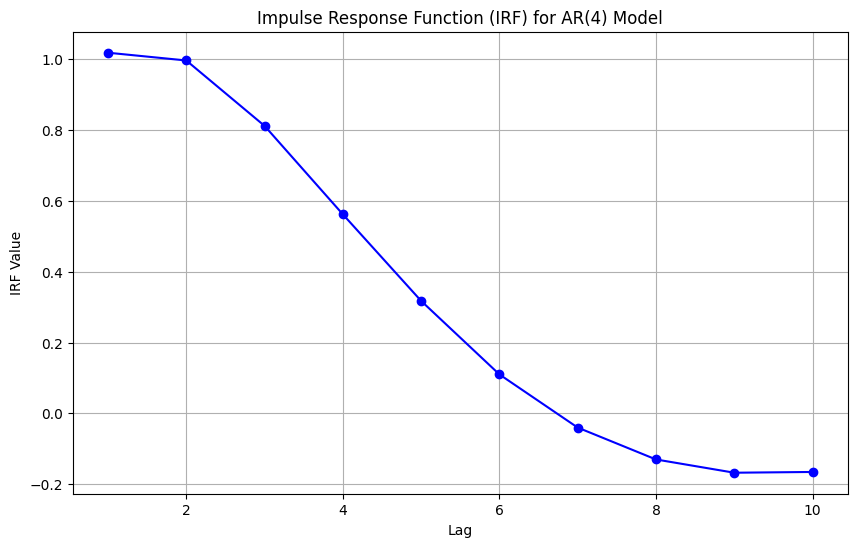

In [40]:
import matplotlib.pyplot as plt

# Plot the Impulse Response Function (IRF)
plt.figure(figsize=(10, 6))
plt.plot(range(1, horizon + 1), irf, marker='o', linestyle='-', color='b')
plt.title('Impulse Response Function (IRF) for AR(4) Model')
plt.xlabel('Lag')
plt.ylabel('IRF Value')
plt.grid(True)
plt.show()

ADF Statistic: -4.605257515743433
p-value: 0.00012631793648402962


/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/ba

Best ARIMA order: (1, 0, 2)
Best AIC: -8402.817327762126
Forecasted CPI Growth Rate for the next 4 months:
2025-01-01    0.003068
2025-02-01    0.002790
2025-03-01    0.002796
2025-04-01    0.002802
Freq: MS, Name: predicted_mean, dtype: float64
Confidence Intervals:
            lower CPI_GrowthRate  upper CPI_GrowthRate
2025-01-01             -0.002196              0.008333
2025-02-01             -0.003025              0.008605
2025-03-01             -0.003154              0.008746
2025-04-01             -0.003266              0.008869


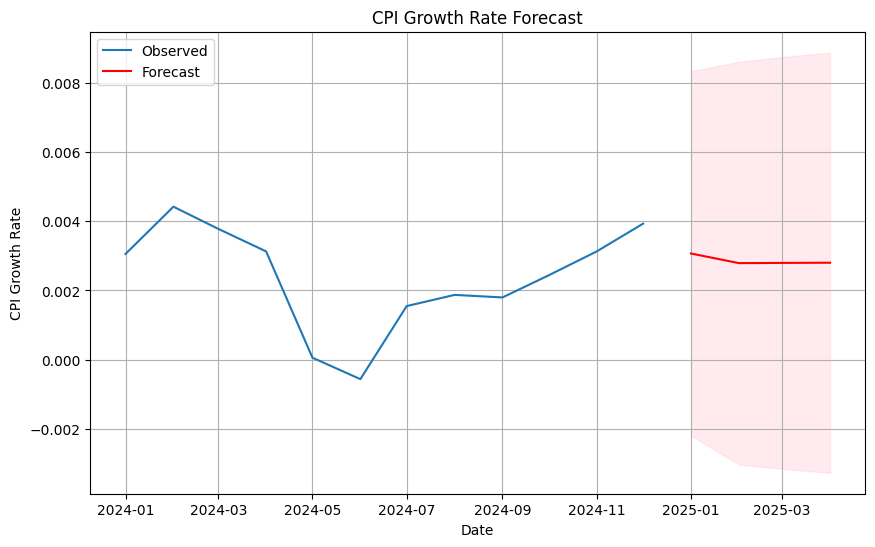

In [42]:
from fredapi import Fred
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import itertools

import statsmodels.api as sm

# Initialize FRED API
fred = Fred(api_key="fe3741e38a5245c3cc826f2d6ae3e1f2")

# Download CPI data from FRED
cpi_series_id = 'CPIAUCSL'  # Consumer Price Index for All Urban Consumers: All Items
cpi_data = fred.get_series(cpi_series_id)

# Convert to a pandas DataFrame and add a date index
cpi_df = pd.DataFrame(cpi_data, columns=[cpi_series_id])
cpi_df.index = pd.to_datetime(cpi_df.index)

# Calculate the growth rate (monthly)
cpi_df['CPI_GrowthRate'] = cpi_df[cpi_series_id].pct_change(1).dropna()

# Perform unit root test (ADF test) to check for stationarity
adf_test = adfuller(cpi_df['CPI_GrowthRate'].dropna())
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])

# Define range for p, d, q
p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(0, 5)
pdq_combinations = list(itertools.product(p_values, d_values, q_values))

best_aic = np.inf
best_order = None
best_model = None

# Grid search to find the best ARIMA(p,d,q) model
for pdq in pdq_combinations:
    try:
        model = ARIMA(cpi_df['CPI_GrowthRate'].dropna(), order=pdq)
        results = model.fit()
        
        # Check AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = pdq
            best_model = results
    except:
        continue

print("Best ARIMA order:", best_order)
print("Best AIC:", best_aic)

# Forecast out of sample for the next 4 months
forecast_steps = 4
forecast = best_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

print("Forecasted CPI Growth Rate for the next 4 months:")
print(forecast_mean)
print("Confidence Intervals:")
print(forecast_conf_int)
# Plot the forecasted CPI Growth Rate
plt.figure(figsize=(10, 6))
plt.plot(cpi_df.index[-12:], cpi_df['CPI_GrowthRate'][-12:], label='Observed')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title('CPI Growth Rate Forecast')
plt.xlabel('Date')
plt.ylabel('CPI Growth Rate')
plt.legend()
plt.grid(True)
plt.show()